In [7]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import pandas as pd

In [8]:
def read_data(file_path):
    edges = []
    with open(file_path, "r") as file:
        for line in file.readlines():
            nodes = line.strip().split('\t')  # split by tab
            edge = (nodes[0], nodes[1], float(nodes[2]))  # store nodes and convert similarity score to float
            edges.append(edge)
    return edges

file_path = "data/lit-bm-13.txt"
ppi_edges = read_data(file_path)

In [9]:
unique_nodes = set()

for edge in ppi_edges:
    unique_nodes.add(edge[0])
    unique_nodes.add(edge[1])

print("Number of nodes in PPI graph:", len(unique_nodes))

Number of nodes in PPI graph: 5545


In [10]:
unique_edges = set()

for edge in ppi_edges:
    sorted_edge = tuple(sorted(map(str, edge)))
    unique_edges.add(sorted_edge)

print("Number of unique edges in PPI graph:", len(unique_edges))

Number of unique edges in PPI graph: 11045


In [11]:
def create_adjacency_list(edges):
    adj_list = {}
    for edge in edges:
        src, dest, _ = edge
        if src == dest: 
            continue
        if src not in adj_list:
            adj_list[src] = []
        if dest not in adj_list:
            adj_list[dest] = []
        # ignore multi-edges
        if dest not in adj_list[src]:
            adj_list[src].append(dest)
        if src not in adj_list[dest]:
            adj_list[dest].append(src)
    return adj_list

adj_list = create_adjacency_list(ppi_edges)

In [12]:
def random_split(edges, test_size=0.5, random_state=42):
    train_edges, test_edges = train_test_split(edges, test_size=test_size, random_state=random_state)
    return train_edges, test_edges

train_edges, test_edges = random_split(ppi_edges)

In [13]:
adj_list = create_adjacency_list(train_edges)

In [14]:
def common_neighbors_score(adj_list):
    cn_scores = {}
    
    for node_u, neighbors_u in adj_list.items():
        for idx_x, node_x in enumerate(neighbors_u):
            for idx_v in range(idx_x + 1, len(neighbors_u)):
                node_v = neighbors_u[idx_v]
                pair = (min(node_x, node_v), max(node_x, node_v))
                cn_scores[pair] = cn_scores.get(pair, 0) + 1

    return cn_scores

start_time = time.time()

cn_scores = common_neighbors_score(adj_list)

end_time = time.time()

execution_time = end_time - start_time

print(f"Time: {execution_time}")

Time: 0.07100224494934082


In [15]:
def jaccard_coefficient(adj_list):
    jc_scores = {}
    
    neighbors_as_sets = {node: set(neighbors) for node, neighbors in adj_list.items()}

    for k, neighbors in adj_list.items():
        for i in neighbors:
            for j in neighbors:
                if i >= j:  # to avoid double computation and direct neighbors
                    continue
                pair = (i, j)
                if pair not in jc_scores:
                    intersection_size = len(neighbors_as_sets[i].intersection(neighbors_as_sets[j]))
#                     non_common_i = len(neighbors_as_sets[i].difference(neighbors_as_sets[j]))
#                     non_common_j = len(neighbors_as_sets[j].difference(neighbors_as_sets[i]))
                    union_size = len(neighbors_as_sets[i]) + len(neighbors_as_sets[j]) - intersection_size
                    
                    jc_score = intersection_size / union_size if union_size > 0 else 0
                    jc_scores[pair] = jc_score

    return jc_scores

start_time = time.time()

jc_scores = jaccard_coefficient(adj_list)

end_time = time.time()

execution_time = end_time - start_time

print(f"Time: {execution_time}")

Time: 0.07526254653930664


In [16]:
def adamic_adar_index(adj_list):
    aa_scores = {}
    degrees = {node: len(neighbors) for node, neighbors in adj_list.items()}

    for k, neighbors in adj_list.items():
        for i in neighbors:
            for j in neighbors:
                if i != j:
                    pair = (min(i, j), max(i, j))
                    if pair not in aa_scores:
                        aa_scores[pair] = 0
                    aa_scores[pair] += 1 / (math.log(degrees[k]) if degrees[k] > 1 else 1)

    return aa_scores

start_time = time.time()

aa_scores = adamic_adar_index(adj_list)

end_time = time.time()

execution_time = end_time - start_time

print(f"Time: {execution_time}")

Time: 0.14515113830566406


In [17]:
def preferential_attachment(adj_list):
    pa_scores = {}
    degrees = {node: len(neighbors) for node, neighbors in adj_list.items()}
    nodes = list(adj_list.keys())

    for idx_x, node_x in enumerate(nodes):
        for node_y in nodes[idx_x + 1:]:  # Only consider nodes after node_x to avoid double computation
            pair = (node_x, node_y)
            if pair not in adj_list[node_x]:  # Optional: only compute for non-existing edges
                pa_score = degrees[node_x] * degrees[node_y]
                pa_scores[pair] = pa_score

    return pa_scores

start_time = time.time()

pa_scores = preferential_attachment(adj_list)

end_time = time.time()

execution_time = end_time - start_time

print(f"Time: {execution_time}")

Time: 8.856539964675903


In [18]:
def degree_normalized_l3_scores(adj_list):
    degrees = {node: len(neighbors) for node, neighbors in adj_list.items()}
    l3_scores_dict = {}

    for node_u, neighbors_u in adj_list.items():
        for idx_x, node_x in enumerate(neighbors_u):
            for idx_v in range(idx_x + 1, len(neighbors_u)):
                node_v = neighbors_u[idx_v]
                for node_y in adj_list[node_v]:
                    if node_y not in adj_list[node_x]:  # check if node_x and node_y are not directly connected
                        pair = tuple(sorted((node_x, node_y)))
                        normalization_factor = 1 / np.sqrt(degrees[node_u] * degrees[node_v])
                        l3_scores_dict[pair] = l3_scores_dict.get(pair, 0) + normalization_factor

    return l3_scores_dict

start_time = time.time()

normalized_l3_scores = degree_normalized_l3_scores(adj_list)

end_time = time.time()

execution_time = end_time - start_time

print(f"Time: {execution_time}")

Time: 0.7800335884094238


In [19]:
#L3N(f1) computation

def compute_L3N(x, y, neighbors):
    U = neighbors[x] - {y}
    V = neighbors[y] - {x}
    
    if not U or not V:
        return 0

    term1 = len(U) / len(neighbors[x])
    term2 = len(V) / len(neighbors[y])
    term3 = 0
    
    intersection_counts_UV = {u: len(neighbors[u].intersection(V)) for u in U}
    intersection_counts_VU = {v: len(neighbors[v].intersection(U)) for v in V}

    for u in U:
        for v in V:
            f_Nu_V = intersection_counts_UV[u] / len(neighbors[u])
            f_Nv_U = intersection_counts_VU[v] / len(neighbors[v])
            f_Nv_Nx = len(neighbors[v].intersection(neighbors[x])) / len(neighbors[v])
            f_Nu_Ny = len(neighbors[u].intersection(neighbors[y])) / len(neighbors[u])
            term3 += f_Nu_V * f_Nv_U * f_Nv_Nx * f_Nu_Ny

    return term1 * term2 * term3

def compute_all_L3N(adj_list):
    nodes = list(adj_list.keys())
    neighbors = {node: set(adj_list[node]) for node in nodes}
    L3N_scores = {}

    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if nodes[j] not in neighbors[nodes[i]]:
                pair = (nodes[i], nodes[j])
                L3N_score = compute_L3N(*pair, neighbors)
                L3N_scores[pair] = L3N_score

    return L3N_scores

start_time = time.time()

normalized_l3n_scores = compute_all_L3N(adj_list)

end_time = time.time()

execution_time = end_time - start_time

print(f"Time: {execution_time}")

Time: 200.12236857414246


In [20]:
with open("normalized_l3n_scores.txt", "w") as file:
    for pair, score in normalized_l3n_scores.items():
        x, y = pair
        file.write(f"{x}\t{y}\t{score}\n")

In [21]:
#L3N(f2) computation

def compute_L3N2(x, y, neighbors):
    U = neighbors[x] - {y}
    V = neighbors[y] - {x}
    
    if not U or not V:
        return 0

    term1 = len(neighbors[x].intersection(U)) / len(neighbors[x].union(U)) if len(neighbors[x]) > 0 else 0
    term2 = len(neighbors[y].intersection(V)) / len(neighbors[y].union(V)) if len(neighbors[y]) > 0 else 0
    term3 = 0
    
    jaccard_UV = {u: len(neighbors[u].intersection(V)) / len(neighbors[u].union(V)) for u in U}
    jaccard_VU = {v: len(neighbors[v].intersection(U)) / len(neighbors[v].union(U)) for v in V}
    
    for u in U:
        f_Nu_V = jaccard_UV[u]
        f_Nu_Ny = len(neighbors[u].intersection(neighbors[y])) / len(neighbors[u].union(neighbors[y])) if len(neighbors[u]) > 0 else 0
        for v in V:
            f_Nv_U = jaccard_VU[v]
            f_Nv_Nx = len(neighbors[v].intersection(neighbors[x])) / len(neighbors[v].union(neighbors[x])) if len(neighbors[v]) > 0 else 0
            term3 += f_Nu_V * f_Nv_U * f_Nv_Nx * f_Nu_Ny

    return term1 * term2 * term3

def compute_all_L3N2(adj_list):
    nodes = list(adj_list.keys())
    neighbors = {node: set(adj_list[node]) for node in nodes}
    L3N_scores = {}

    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if nodes[j] not in neighbors[nodes[i]]:
                pair = (nodes[i], nodes[j])
                L3N_score = compute_L3N2(*pair, neighbors)
                L3N_scores[pair] = L3N_score

    return L3N_scores

start_time = time.time()

normalized_l3n_scores2 = compute_all_L3N2(adj_list)

end_time = time.time()

execution_time = end_time - start_time

print(f"Time: {execution_time}")

Time: 235.27000761032104


In [22]:
with open("normalized_l3n_scores2.txt", "w") as file:
    for pair, score in normalized_l3n_scores2.items():
        x, y = pair
        file.write(f"{x}\t{y}\t{score}\n")

In [23]:
def compute_CRA(adj_list):
    nodes = list(adj_list.keys())
    CRA_scores = {}

    neighbors = {node: set(adj_list[node]) for node in nodes}

    for i, node_x in enumerate(nodes):
        for node_y in nodes[i+1:]:
            pair = (node_x, node_y)
            common_neighbors = neighbors[node_x] & neighbors[node_y]
            CRA_score = sum(len(neighbors[a] & common_neighbors) / len(neighbors[a]) for a in common_neighbors)
            CRA_scores[pair] = CRA_score
            CRA_scores[(node_y, node_x)] = CRA_score  # Since the graph is undirected

    return CRA_scores


start_time = time.time()

CRA_scores = compute_CRA(adj_list)

end_time = time.time()

execution_time = end_time - start_time

print(f"Time: {execution_time}")

Time: 49.56029033660889


In [24]:
def compute_Sim(adj_list):
    nodes = list(adj_list.keys())
    Sim_scores = {}

    neighbors = {node: set(adj_list[node]) for node in nodes}

    for i, node_x in enumerate(nodes):
        for node_y in nodes[i+1:]:
            U = neighbors[node_x] & neighbors[node_y]
            V = neighbors[node_y] & neighbors[node_x]

            Sim_score_x = sum(len(neighbors[v] & neighbors[node_x]) / len(neighbors[v] | neighbors[node_x]) for v in V)
            Sim_score_y = sum(len(neighbors[u] & neighbors[node_y]) / len(neighbors[u] | neighbors[node_y]) for u in U)

            Sim_score = Sim_score_x + Sim_score_y
            pair = (node_x, node_y)
            Sim_scores[pair] = Sim_score
            Sim_scores[(node_y, node_x)] = Sim_score  # Since the graph is undirected

    return Sim_scores

start_time = time.time()

Sim_scores = compute_Sim(adj_list)

end_time = time.time()

execution_time = end_time - start_time

print(f"Time: {execution_time}")

Time: 34.788673400878906


In [25]:
def borda_count(rankings):

    counts = {}
    for ranking in rankings:
        for i, item in enumerate(ranking):
            if item not in counts:
                counts[item] = 0
            counts[item] += len(ranking) - i - 1  #the number of items ranked below this item
    return counts

cn_ranking = sorted(cn_scores.items(), key=lambda x: x[1], reverse=True)
l3_ranking = sorted(normalized_l3_scores.items(), key=lambda x: x[1], reverse=True)
l3n_ranking = sorted(normalized_l3n_scores.items(), key=lambda x: x[1], reverse=True)
l3n_ranking2 = sorted(normalized_l3n_scores2.items(), key=lambda x: x[1], reverse=True)

cn_ranking = [item for item, score in cn_ranking]
l3_ranking = [item for item, score in l3_ranking]
l3n_ranking = [item for item, score in l3n_ranking]
l3n_ranking2 = [item for item, score in l3n_ranking2]

borda_counts = borda_count([cn_ranking, l3_ranking, l3n_ranking, l3n_ranking2])

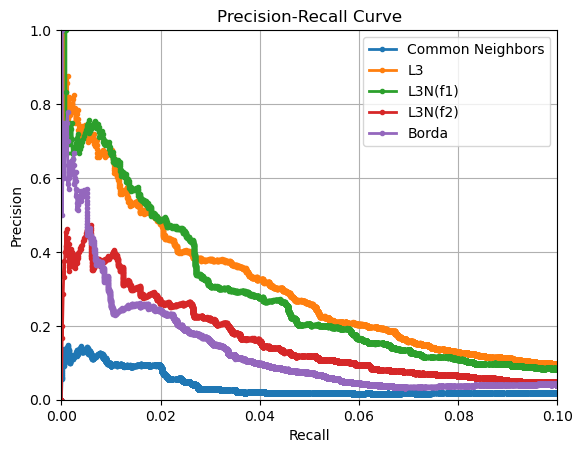

In [32]:
import matplotlib.pyplot as plt
from collections import defaultdict

def precision_recall(test_edges, scores):
    test_edges_set = set(tuple(sorted([edge[0], edge[1]])) for edge in test_edges)
    
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    
    tp = 0
    fp = 0
    precision_recall_values = []

    for (node_i, node_j), score in sorted_scores:
        edge = tuple(sorted((node_i, node_j)))

        if edge in test_edges_set:
            tp += 1
        else:
            fp += 1

        precision = tp / (tp + fp)
        recall = tp / len(test_edges)

        precision_recall_values.append((precision, recall))

    return precision_recall_values


def plot_precision_recall_curves(precision_recall_values_list, labels):
    for idx, precision_recall_values in enumerate(precision_recall_values_list):
        precisions, recalls = zip(*precision_recall_values)
        plt.plot(recalls, precisions, marker='.', label=labels[idx], linewidth=2)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.xlim(0, 0.1)
    plt.ylim(0, 1)
    plt.show()

cn_precision_recall_values_normalized = precision_recall(test_edges, cn_scores)
jc_precision_recall_values_normalized = precision_recall(test_edges, jc_scores)
aa_precision_recall_values_normalized = precision_recall(test_edges, aa_scores)
pa_precision_recall_values_normalized = precision_recall(test_edges, pa_scores)
l3_precision_recall_values_normalized_K = precision_recall(test_edges, normalized_l3_scores)
l3_precision_recall_values_normalized_Y = precision_recall(test_edges, normalized_l3n_scores)
l3_precision_recall_values_normalized_2 = precision_recall(test_edges, normalized_l3n_scores2)
borda_precision_recall_values = precision_recall(test_edges, borda_counts)

plot_precision_recall_curves(
    [cn_precision_recall_values_normalized, l3_precision_recall_values_normalized_K, l3_precision_recall_values_normalized_Y, l3_precision_recall_values_normalized_2, borda_precision_recall_values],
    ['Common Neighbors', 'L3', 'L3N(f1)', 'L3N(f2)', 'Borda']
)

In [35]:
def rank_links_by_score(scores, n):
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_scores[:n]

top_n = 10

cn_ranked_links = rank_links_by_score(cn_scores, top_n)
jc_ranked_links = rank_links_by_score(jc_scores, top_n)
aa_ranked_links = rank_links_by_score(aa_scores, top_n)
pa_ranked_links = rank_links_by_score(pa_scores, top_n)
l3_ranked_links_normalized = rank_links_by_score(normalized_l3_scores, top_n)
l3n_ranked_links_normalized = rank_links_by_score(normalized_l3n_scores, top_n)
l3n2_ranked_links_normalized = rank_links_by_score(normalized_l3n_scores2, top_n)
CRA_ranked_links_normalized = rank_links_by_score(CRA_scores, top_n)
Sim_ranked_links_normalized = rank_links_by_score(Sim_scores, top_n)
borda_ranked_links = rank_links_by_score(borda_counts, top_n)


print("Top", top_n, "Ranked Links by Common Neighbors:")
for i, (link, score) in enumerate(cn_ranked_links, start=1):
    print(f"{i}. {link} (Score: {score:.4f})")

print("\nTop", top_n, "Ranked Links by Jaccard Coefficient:")
for i, (link, score) in enumerate(jc_ranked_links, start=1):
    print(f"{i}. {link} (Score: {score:.4f})")

print("\nTop", top_n, "Ranked Links by Adamic-Adar:")
for i, (link, score) in enumerate(aa_ranked_links, start=1):
    print(f"{i}. {link} (Score: {score:.4f})")

print("\nTop", top_n, "Ranked Links by Preferential Attachment:")
for i, (link, score) in enumerate(pa_ranked_links, start=1):
    print(f"{i}. {link} (Score: {score:.4f})")
    
print("\nTop", top_n, "Ranked Links by L3 metric):")
for i, (link, score) in enumerate(l3_ranked_links_normalized, start=1):
    print(f"{i}. {link} (Score: {score:.4f})")
    
print("\nTop", top_n, "Ranked Links by L3N(f1) metric):")
for i, (link, score) in enumerate(l3n_ranked_links_normalized, start=1):
    print(f"{i}. {link} (Score: {score:.4f})")
    
print("\nTop", top_n, "Ranked Links by L3N(f2) metric):")
for i, (link, score) in enumerate(l3n2_ranked_links_normalized, start=1):
    print(f"{i}. {link} (Score: {score:.4f})")
    
print("\nTop", top_n, "Ranked Links by CRA metric):")
for i, (link, score) in enumerate(CRA_ranked_links_normalized, start=1):
    print(f"{i}. {link} (Score: {score:.4f})")
    
print("\nTop", top_n, "Ranked Links by Sim metric):")
for i, (link, score) in enumerate(Sim_ranked_links_normalized, start=1):
    print(f"{i}. {link} (Score: {score:.4f})")
    
print("\nTop", top_n, "Ranked Links by Borda):")
for i, (link, score) in enumerate(borda_ranked_links, start=1):
    print(f"{i}. {link} (Score: {score:.4f})")

Top 10 Ranked Links by Common Neighbors:
1. ('10499', '8648') (Score: 7.0000)
2. ('5468', '5914') (Score: 6.0000)
3. ('7322', '7323') (Score: 6.0000)
4. ('7321', '7322') (Score: 6.0000)
5. ('7321', '7323') (Score: 6.0000)
6. ('596', '598') (Score: 6.0000)
7. ('2885', '6714') (Score: 5.0000)
8. ('5295', '5296') (Score: 5.0000)
9. ('1956', '3815') (Score: 5.0000)
10. ('23054', '8648') (Score: 5.0000)

Top 10 Ranked Links by Jaccard Coefficient:
1. ('50848', '64061') (Score: 1.0000)
2. ('3856', '4582') (Score: 1.0000)
3. ('3856', '54521') (Score: 1.0000)
4. ('3856', '9732') (Score: 1.0000)
5. ('3856', '4133') (Score: 1.0000)
6. ('3856', '5287') (Score: 1.0000)
7. ('3856', '8491') (Score: 1.0000)
8. ('4582', '54521') (Score: 1.0000)
9. ('4582', '9732') (Score: 1.0000)
10. ('4582', '5287') (Score: 1.0000)

Top 10 Ranked Links by Adamic-Adar:
1. ('7321', '7322') (Score: 12.2518)
2. ('7321', '7323') (Score: 9.7479)
3. ('7322', '7323') (Score: 8.8816)
4. ('5594', '5595') (Score: 7.5541)
5. ('8